## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions
from tensorflow.keras.applications import EfficientNetB7

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
dir_path = "D:\#MINI PROJECT\Dataset_BUSI_with_GT"
IMAGE_SHAPE = (224, 224)

## Function for image preprocessing
Gets the location or the image as input and returns Numpy array

In [3]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

### Reading all the images from each dirctory
read all file from the three directories 'benign', 'malignant' and 'normal'

In [4]:
directories = os.listdir(dir_path) # to get all the available folders in the directory

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)



### Removal of mask images from files

In [5]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

As we see, after removing the mask images the rest of dataset is 780 images which is not enough at all for training model from scratch, so we'll use **EfficientNetB7** model for Transfer Learning
### Prepare the images
prepare the images to be suitable as input for efficientnet model

In [6]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


### Prepare the target for splitting
* convert the images to numpy array for better computation
* encode the label to convert categorical names to numbers

In [7]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


**Split the data to train and test**

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

### Build the Model
* create EfficientNetB7 Model
* don't include_top layers to take only the features of the model
* freeze all layer weights of the model
* append my own layers for Transfer Learning
* compile my own model after Transfer Learning

In [9]:

base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

### Train the model

In [10]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/50
22/22 [==============================] - 162s 7s/step - loss: 1.0392 - sparse_categorical_accuracy: 0.5541 - val_loss: 1.0000 - val_sparse_categorical_accuracy: 0.5641
Epoch 2/50
22/22 [==============================] - 145s 7s/step - loss: 0.6855 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9054 - val_sparse_categorical_accuracy: 0.6410
Epoch 3/50
22/22 [==============================] - 146s 7s/step - loss: 0.5735 - sparse_categorical_accuracy: 0.7792 - val_loss: 0.8404 - val_sparse_categorical_accuracy: 0.6923
Epoch 4/50
22/22 [==============================] - 146s 7s/step - loss: 0.5134 - sparse_categorical_accuracy: 0.8077 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.7564
Epoch 5/50
22/22 [==============================] - 146s 7s/step - loss: 0.4755 - sparse_categorical_accuracy: 0.8219 - val_loss: 0.7971 - val_sparse_categorical_accuracy: 0.6923
Epoch 6/50
22/22 [==============================] - 147s 7s/step - loss: 0.4057 - sparse_categorical_accu

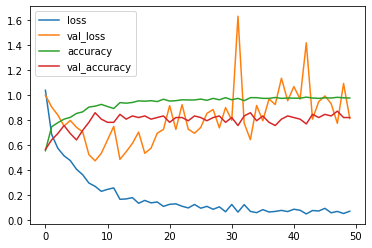

In [11]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

### Evaluate the model

In [12]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 15s 4s/step - loss: 0.8131 - sparse_categorical_accuracy: 0.8205


[0.8131357431411743, 0.8205128312110901]

### Make the last 100 layers as trainable

In [13]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

### Train the model again

In [14]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/50
22/22 [==============================] - 232s 10s/step - loss: 0.4968 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.8556 - val_sparse_categorical_accuracy: 0.8205
Epoch 2/50
22/22 [==============================] - 212s 10s/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.9006 - val_sparse_categorical_accuracy: 0.8590
Epoch 3/50
22/22 [==============================] - 205s 9s/step - loss: 0.1683 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.8718
Epoch 4/50
22/22 [==============================] - 204s 9s/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.7834 - val_sparse_categorical_accuracy: 0.8846
Epoch 5/50
22/22 [==============================] - 205s 9s/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.7688 - val_sparse_categorical_accuracy: 0.8718
Epoch 6/50
22/22 [==============================] - 209s 10s/step - loss: 0.0767 - sparse_categorical_a

### Evaluate the model

In [15]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 16s 5s/step - loss: 0.8807 - sparse_categorical_accuracy: 0.8462


[0.8806784152984619, 0.8461538553237915]

### Predict the model

In [16]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

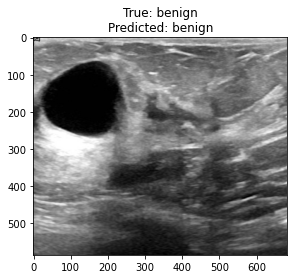

In [17]:
predict_image(dir_path + '/benign/benign (10).png', 'benign')

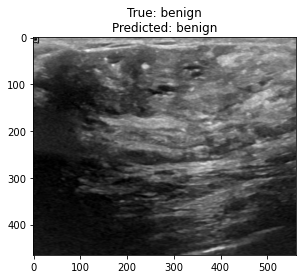

In [18]:
predict_image(dir_path + '/benign/benign (85).png', 'benign')

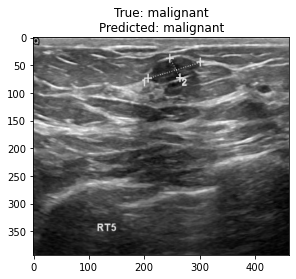

In [19]:
predict_image(dir_path + '/malignant/malignant (10).png', 'malignant')

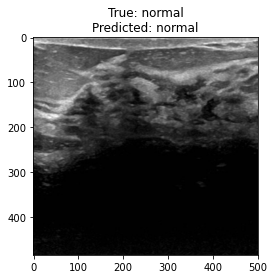

In [20]:
predict_image(dir_path + '/normal/normal (10).png', 'normal')

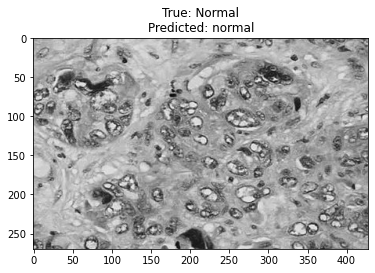

In [26]:
predict_image(r"D:\CSE 3rd yr\Micrograph_of_invasive_ductal_carcinoma_with_marked_nuclear_pleomorphism.png", 'Normal')

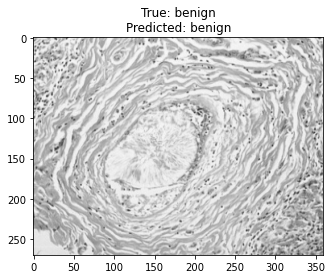

In [24]:
predict_image(r"D:\CSE 3rd yr\benignex2.png", 'benign')

In [25]:
incept_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      